In [6]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from wmfdata import hive
from wmfdata.charting import comma_fmt, pct_fmt, M_fmt
from wmfdata.utils import pct_str

In [7]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [8]:
m = pd.read_csv(
    "../metrics/metrics.tsv", 
    sep="\t",
    parse_dates=["month"]
).set_index("month")

# Wiki segments

In [9]:
def wiki_segment(w):
    next_10_wps = (
        "eswiki", "dewiki", "jawiki", "frwiki", "ruwiki",
        "itwiki", "zhwiki", "ptwiki", "plwiki", "nlwiki"
    )
    
    if w == "enwiki":
        return "English Wikipedia"
    elif w in next_10_wps:
        return "'next 10' Wikipedias"
    elif w == "commonswiki":
        return "Commons"
    elif w == "wikidatawiki":
        return "Wikidata"
    else:
        return "other projects"

# Global editors dataset

In [55]:
%%time
global_eds_r = hive.run("""
select 
    month,
    tenure,
    count(*) as eds,
    sum(cast(content_edits >= 5 as int)) as active_eds,
    sum(cast(content_edits >= 100 as int)) as very_active_eds
from (
    select
        month,
        user_name,
        sum(edits) as edits,
        sum(content_edits) as content_edits,
        if(
            trunc(min(user_registration), "MONTH") = month,
            "new",
            "returning"
        ) as tenure,
        max(bot_by_group) as bot -- `bot_by_group` uses both group and name strategies
    from neilpquinn.editor_month
    where 
        month >= "{start}" and
        user_id != 0
    group by month, user_name
) global_edits
where
    not bot
group by month, tenure
""".format(start="2001-01-01"))

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 1min 48s


In [56]:
global_eds = (
    global_eds_r
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index(["month"])
    .pivot(columns="tenure")
    .fillna(0)
)

global_eds.tail()

eds           active_eds           very_active_eds  \
tenure_group       new returning        new returning             new   
month                                                                   
2019-01-01    119086.0  189145.0    17096.0   69686.0           343.0   
2019-02-01    110454.0  182691.0    16335.0   66219.0           317.0   
2019-03-01    118835.0  192814.0    17738.0   69973.0           370.0   
2019-04-01    104935.0  189484.0    15535.0   68824.0           331.0   
2019-05-01    112964.0  191899.0    19323.0   70888.0           397.0   

                        
tenure_group returning  
month                   
2019-01-01     14029.0  
2019-02-01     13117.0  
2019-03-01     13681.0  
2019-04-01     13215.0  
2019-05-01     13677.0

# Per-wiki editors dataset

In [76]:
wiki_eds_r = hive.run("""
select 
    wiki,
    database_group as site_group,
    month,
    tenure,
    count(*) as eds,
    sum(cast(content_edits >= 5 as int)) as active_eds,
    sum(cast(content_edits >= 100 as int)) as very_active_eds
from (
    select
        wiki,
        database_group,
        month,
        if(
            trunc(user_registration, "MONTH") = month,
            "new",
            "returning"
        ) as tenure,
        edits,
        content_edits
    from neilpquinn.editor_month
    inner join canonical_data.wikis
    on wiki = database_code
    where
        month >= "{start}" and
        user_id != 0 and
        not bot_by_group -- `bot_by_group` uses both group and name strategies
) wiki_editors
group by 
    wiki,
    database_group,
    month,
    tenure
order by
    wiki,
    database_group,
    month,
    tenure
limit 1000000
""".format(start="2001-01-01"))

In [82]:
wiki_eds = (
    wiki_eds_r
    .drop("site_group", axis=1)
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index(["wiki", "month"])
    .pivot(columns="tenure")
    .fillna(0)
)

wiki_eds.xs("enwiki").tail()

eds           active_eds           very_active_eds          
tenure          new returning        new returning             new returning
month                                                                       
2019-01-01  52895.0   90342.0     5556.0   26405.0            83.0    3615.0
2019-02-01  48775.0   87291.0     5105.0   25059.0            66.0    3314.0
2019-03-01  52815.0   93208.0     5856.0   26786.0            88.0    3511.0
2019-04-01  46948.0   92153.0     5103.0   26753.0            84.0    3411.0
2019-05-01  44745.0   91688.0     4916.0   26637.0            84.0    3497.0

# Tenure groups

In [85]:
group_size = (
    global_eds[-12:]
    .mean()
    .unstack()
)

group_size.applymap(round)

tenure_group,new,returning
eds,109271,182014
active_eds,16168,66721
very_active_eds,340,13202


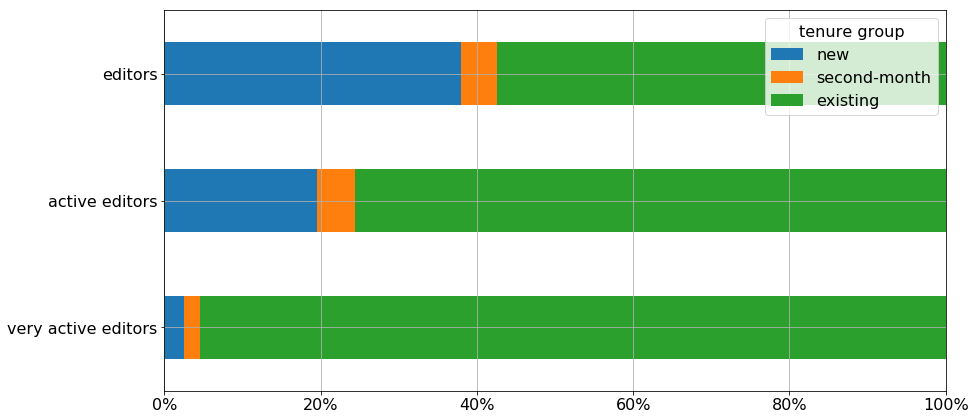

In [12]:
ax = (
    global_eds[-12:]
    .mean()
    .unstack()
    .reindex(["new", "second-month", "existing"], axis=1)
    .reindex(["very_active_eds", "active_eds", "eds"])
    .apply(lambda row: row / row.sum(), axis=1)
    .rename(index={
        "eds": "editors",
        "active_eds": "active editors",
        "very_active_eds": "very active editors"
    })
    .plot.barh(stacked=True)
)

ax.xaxis.set_major_formatter(pct_fmt)
plt.legend(title="tenure group");

# Overall trends in different activity groups

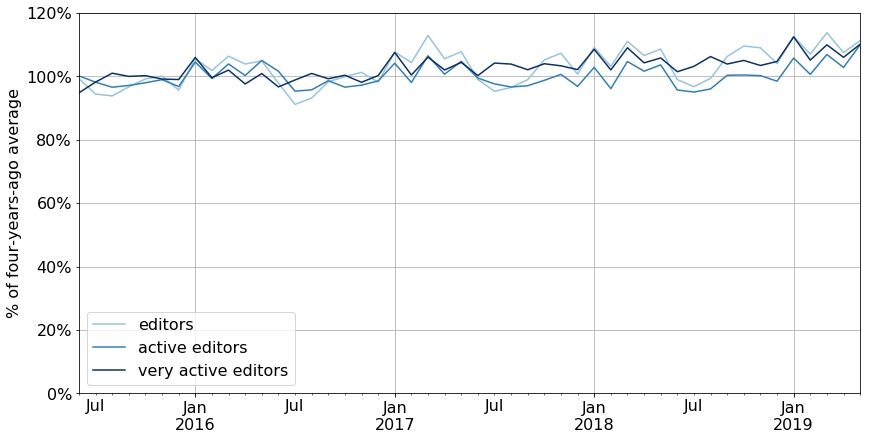

In [92]:
recent_global_eds = global_eds.sum(axis=1, level=0)[-48:]
start_index = recent_global_eds[1:13].mean()

colors = plt.get_cmap("Blues")(np.linspace(0.4, 1, 3))
ax = (
    (recent_global_eds / start_index)
    .rename(columns={
        "eds": "editors",
        "active_eds": "active editors",
        "very_active_eds": "very active editors"
    })
    .plot(ylim=(0, 1.2), color=colors)
)
plt.ylabel("% of four-years-ago average")
plt.xlabel("")
ax.yaxis.set_major_formatter(pct_fmt)

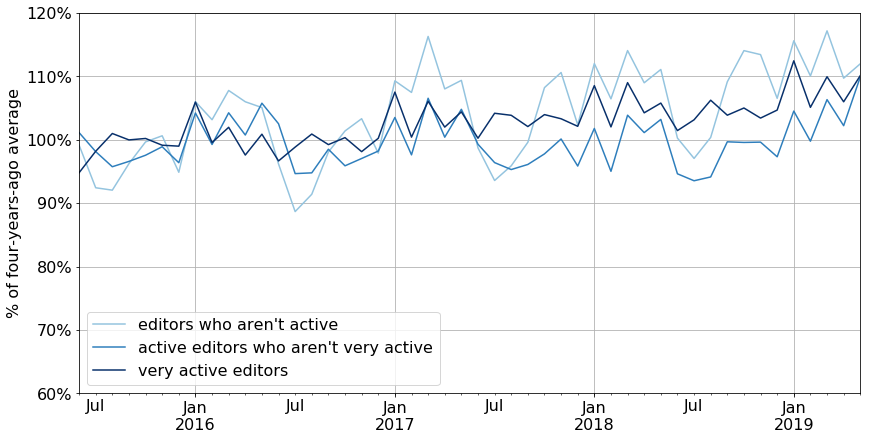

In [96]:
unnested_global_eds = (
    recent_global_eds
    .assign(
        eds=lambda df: df["eds"] - df["active_eds"] - df["very_active_eds"],
        active_eds=lambda df: df["active_eds"] - df["very_active_eds"]
    )
)

start_index = unnested_global_eds[1:13].mean()
ax = (unnested_global_eds / start_index).rename(columns={
    "eds": "editors who aren't active",
    "active_eds": "active editors who aren't very active",
    "very_active_eds": "very active editors"
}).plot(ylim=(0.6, 1.2), color=colors)
plt.ylabel("% of four-years-ago average")
plt.xlabel("")
plt.legend(loc="lower left")
ax.yaxis.set_major_formatter(pct_fmt)

# Returning active editors

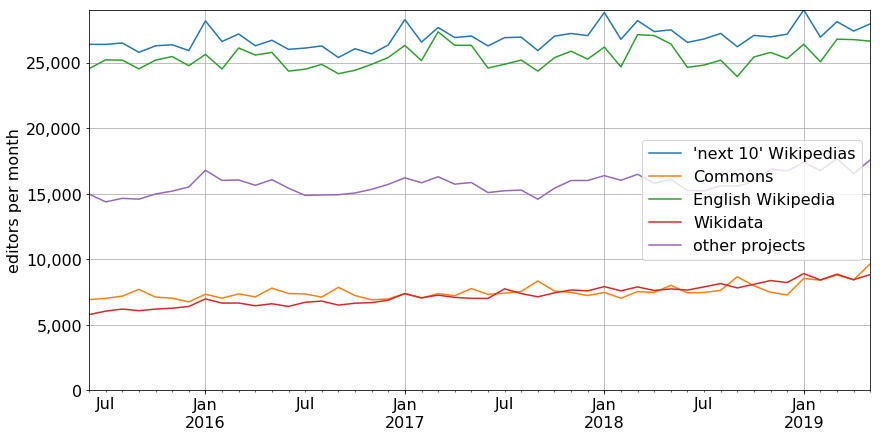

In [100]:
ax = (
    wiki_eds
    .xs(("active_eds", "returning"), axis=1, drop_level=True)
    .to_frame()
    .unstack("wiki")
    .stack([0, 1])
    .reset_index([1, 2], drop=True)
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .iloc[-48:]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");

# New active editors

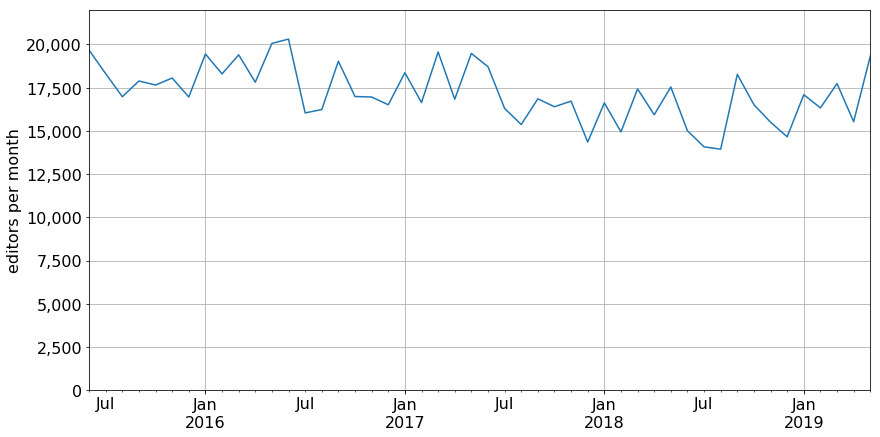

In [113]:
ax = global_eds[("active_eds", "new")][-48:].plot(ylim=(0, 22000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

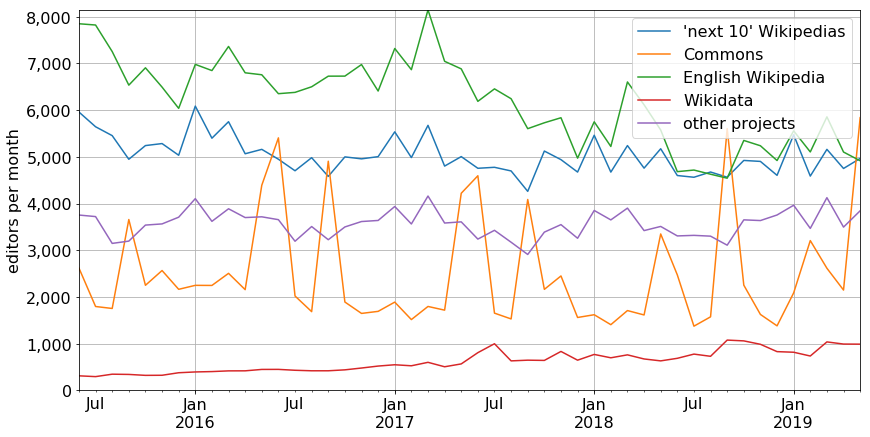

In [116]:
ax = (
    wiki_eds
    .xs(("active_eds", "new"), axis=1, drop_level=True)
    .to_frame()
    .unstack("wiki")
    .stack([0, 1])
    .reset_index([1, 2], drop=True)
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .iloc[-48:]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");

# Very active editors

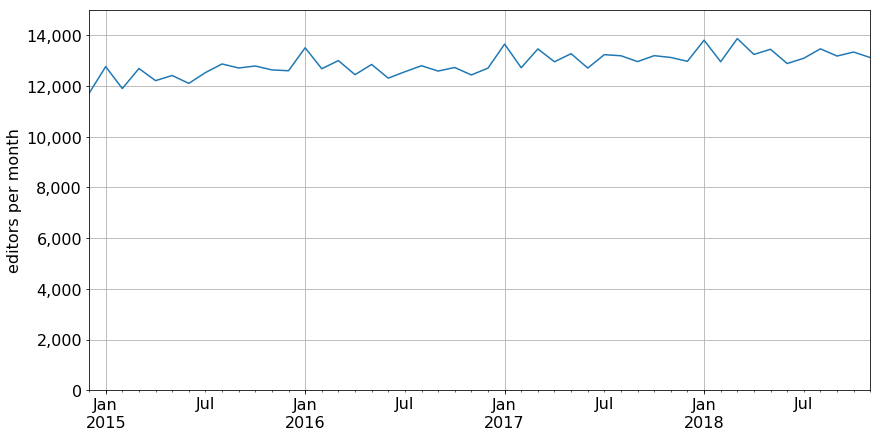

In [224]:
ax = global_eds.loc["2014-12-01":, "very_active_eds"].sum(axis=1).plot(ylim=(0, 15000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

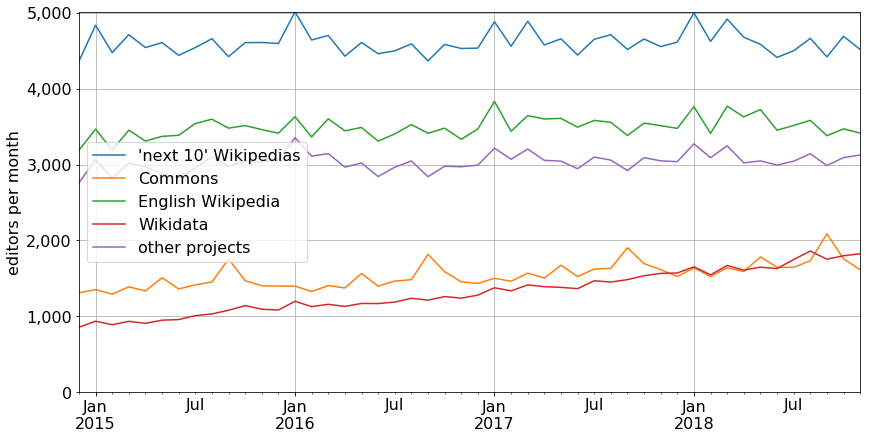

In [234]:
ax = (
    wiki_eds
    .xs(("very_active_eds"), axis=1, drop_level=True)
    .sum(axis=1)
    .unstack("wiki")
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .loc["2014-12-01":]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");